#Taste
Arieli, E., Gerbi, R., Shein-Idelson, M., & Moran, A. (2020). Temporally-precise basolateral amygdala activation is required for the formation of taste memories in gustatory cortex. Journal of Physiology, 598(23), 5505–5522. https://doi.org/10.1113/JP280213

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal
from scipy.ndimage import gaussian_filter1d

loading the data

In [2]:
# before CTA
sd_c = pd.read_pickle('https://raw.githubusercontent.com/regevti/sensory-systems-workshop/master/Taste/sd_c_all.pkl')
# after CTA
sd_t = pd.read_pickle('https://raw.githubusercontent.com/regevti/sensory-systems-workshop/master/Taste/sd_t_all.pkl')

sessions in the experiment

In [3]:
sessions = pd.DataFrame([{'session': name,'#Neurons': len(session['neurons'])} for name, session in sd_c.items()])
sessions

,session,#Neurons
0,sde14,4
1,SDE19,14
2,SDE20,14
3,SDE21-03-09-19-S-CAROUSELLE_190903_104651,9
4,SDE22,13
5,SDE24,15
6,sde4,8
7,sde5,16
8,sde8,7


In [4]:
session = sd_c['SDE24']
tastes = list(session['event_times'].keys())
print(f'Tastes: {tastes}')

Tastes: ['water', 'sugar', 'nacl', 'CA']


###Times of tastants stimuli

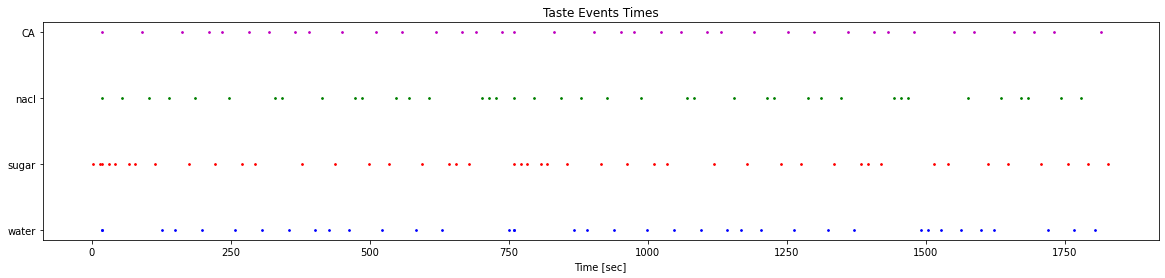

In [5]:
plt.figure(figsize=(20,4))
colors = ['b', 'r', 'g', 'm']
for i, taste in enumerate(tastes):
  events = session['event_times'][taste]
  plt.scatter(events, i*np.ones((len(events),)), color=colors[i], s=3)

plt.yticks(ticks=np.arange(len(tastes)), labels=tastes);
plt.xlabel('Time [sec]');
plt.title('Taste Events Times');

In [6]:
def raster_align(session, neuron_id, taste, is_plot=True, bins=None):
  bins = np.arange(-0.5, 0.5, 0.005) if bins is None else bins
  spikes = session['neurons'][neuron_id][2]
  events = session['event_times'][taste]
  n_events = len(events)
  raster = np.zeros((n_events, len(bins)-1))
  for i, ev_time in enumerate(events):
    ev_bins = bins + ev_time
    raster[i,:] = np.histogram(spikes, bins=ev_bins)[0]

  return raster, bins


def get_pre_post_stim(psth):
  stim_id = int(len(psth)/2)
  pre = psth[:stim_id]
  post = psth[stim_id:]
  return pre, post


def plot_taste_psth(session, neuron_id, taste, axes=None):
  if axes is None:
    fig, axes = plt.subplots(2, 1, figsize=(10,7))
  raster, bins = raster_align(session, neuron_id, taste)
  n_events = raster.shape[0]
  axes[0].imshow(raster>0, cmap='Greys', aspect=bins[1]-bins[0], 
                    extent=(bins[0], bins[-1], 0, n_events))
  axes[0].vlines(0, 0, n_events, linestyles='--', colors='r')
  axes[0].set_title(taste)
  axes[0].set_ylabel('Trials')
  psth = raster.mean(axis=0)
  axes[1].plot(bins[1:], psth);
  axes[1].plot(bins[1:], gaussian_filter1d(psth, sigma=1), '--')
  axes[1].autoscale(enable=True, axis='x', tight=True)
  axes[1].vlines(0, 0, n_events, linestyles='--', colors='r')
  axes[1].set_ylim([0, max(0.5, psth.max())])

  return psth

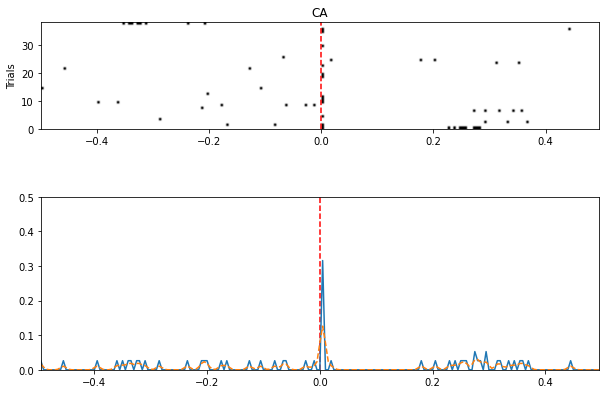

In [7]:
psth = plot_taste_psth(session, 13, 'CA')

##Statistical Tools for Neural Selectivity

checking whether the distribution of neural firing rate is normally distributed

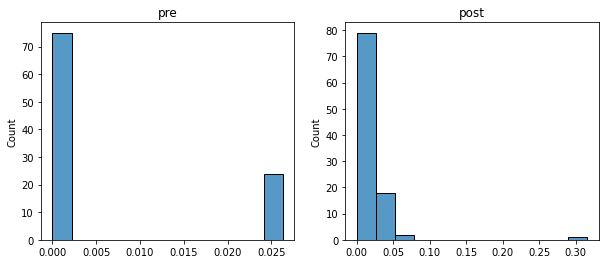

In [8]:
pre, post = get_pre_post_stim(psth)
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.histplot(pre, bins=12, ax=axes[0])
axes[0].set_title('pre')
sns.histplot(post, bins=12, ax=axes[1])
axes[1].set_title('post');

###Skewness and Kurstosis - Tests for normal distribution
Skewness - measures the symmetry of the distribution  
Kurtosis - determines the heaviness of the distribution tails

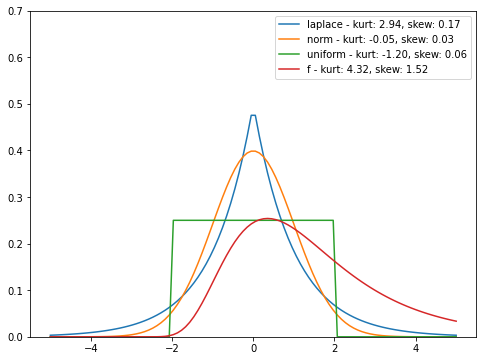

In [9]:
x = np.linspace(-5, 5, 100)
fig, ax = plt.subplots(1,1,figsize=(8,6))
distnames = ['laplace', 'norm', 'uniform', 'f']
for distname in distnames:
    if distname == 'uniform':
        dist = getattr(stats, distname)(loc=-2, scale=4)
    elif distname == 'f':
        dist = getattr(stats, distname)(loc=-3, scale=4, dfn=29, dfd=18)
    else:
        dist = getattr(stats, distname)

    data = dist.rvs(size=1000, random_state=0)
    kur = stats.kurtosis(data, fisher=True)
    skewness = stats.skew(data)
    y = dist.pdf(x)
    ax.plot(x, y, label=f"{distname} - kurt: {kur:.2f}, skew: {skewness:.2f}")
    ax.set_ylim([0, 0.7])
    ax.legend()

Skewness and Kurtosis for pre and post PSTH

In [10]:
print(f'Pre - skewness: {stats.skew(pre):.2f}, kurtosis: {stats.kurtosis(pre):.2f}')
print(f'Post - skewness: {stats.skew(post):.2f}, kurtosis: {stats.kurtosis(post):.2f}')

Pre - skewness: 1.20, kurtosis: -0.56
Post - skewness: 8.00, kurtosis: 70.71


###Statistical Tests


####Welch t-test
2-sided test for the means of populations with different variances

In [11]:
t, p = stats.ttest_ind(pre, post, equal_var=False)
print(f't = {t:.3f}')
# half p for one sided test
print(f'p = {p:.3f}')

t = -0.730
p = 0.467


####Mann-Whitney U Test
non-parametric test for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X.

In [12]:
u, p = stats.mannwhitneyu(pre, post)
print(f'U = {u:.3f}')
print(f'p = {p:.3f}')

U = 4825.500
p = 0.337


###Plotting all Tastes PSTH with Statistical Tests

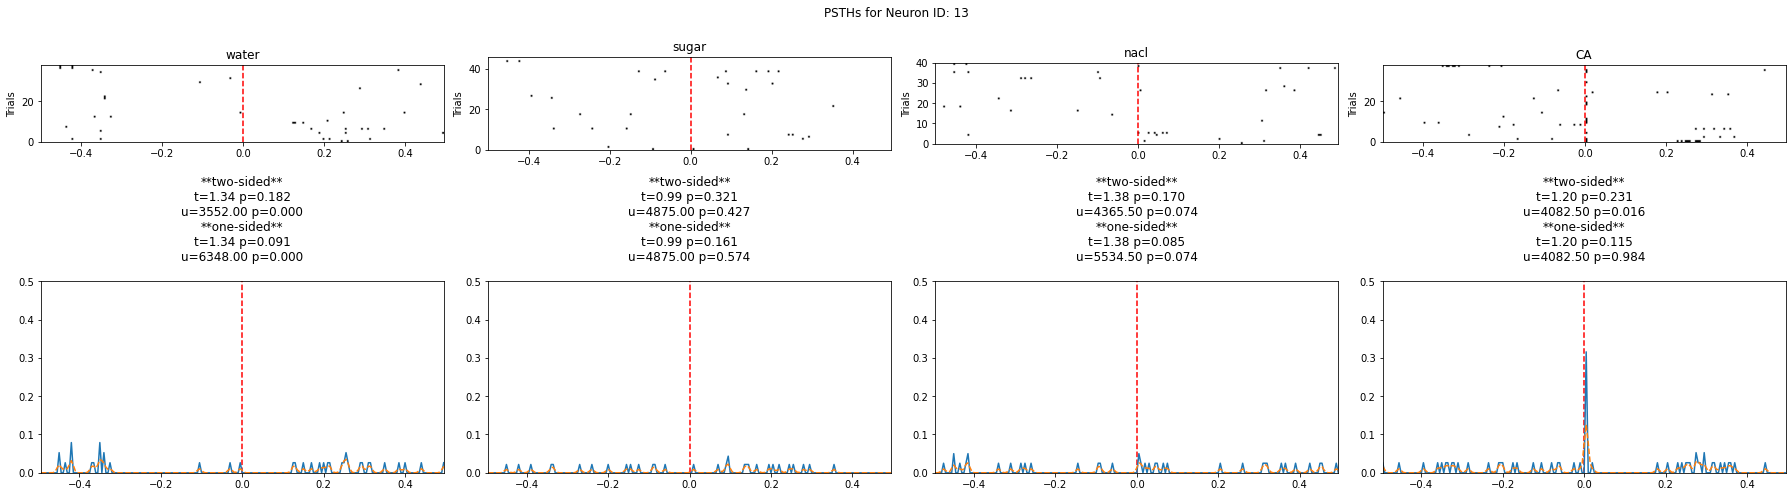

In [13]:
def plot_all_tastes_psth(session, neuron_id):
  fig, axes = plt.subplots(2, len(tastes), figsize=(25,7))
  for i, taste in enumerate(tastes):
    psth = plot_taste_psth(session, neuron_id, taste, axes[:,i])
    psth = gaussian_filter1d(psth, sigma=1)
    pre, post = get_pre_post_stim(psth)
    title = '**two-sided**\n'
    title += 't={0:.2f} p={1:.3f}\n'.format(*stats.ttest_ind(post, pre, equal_var=False))
    title += 'u={0:.2f} p={1:.3f}\n'.format(*stats.mannwhitneyu(post, pre))
    title += '**one-sided**\n'
    t, p = stats.ttest_ind(post, pre, equal_var=False)
    title += 't={0:.2f} p={1:.3f}\n'.format(t, p/2)
    title += 'u={0:.2f} p={1:.3f}\n'.format(*stats.mannwhitneyu(post, pre, alternative='greater'))
    axes[1, i].set_title(title)

  fig.suptitle(f'PSTHs for Neuron ID: {neuron_id}')
  fig.tight_layout()


plot_all_tastes_psth(session, 13)

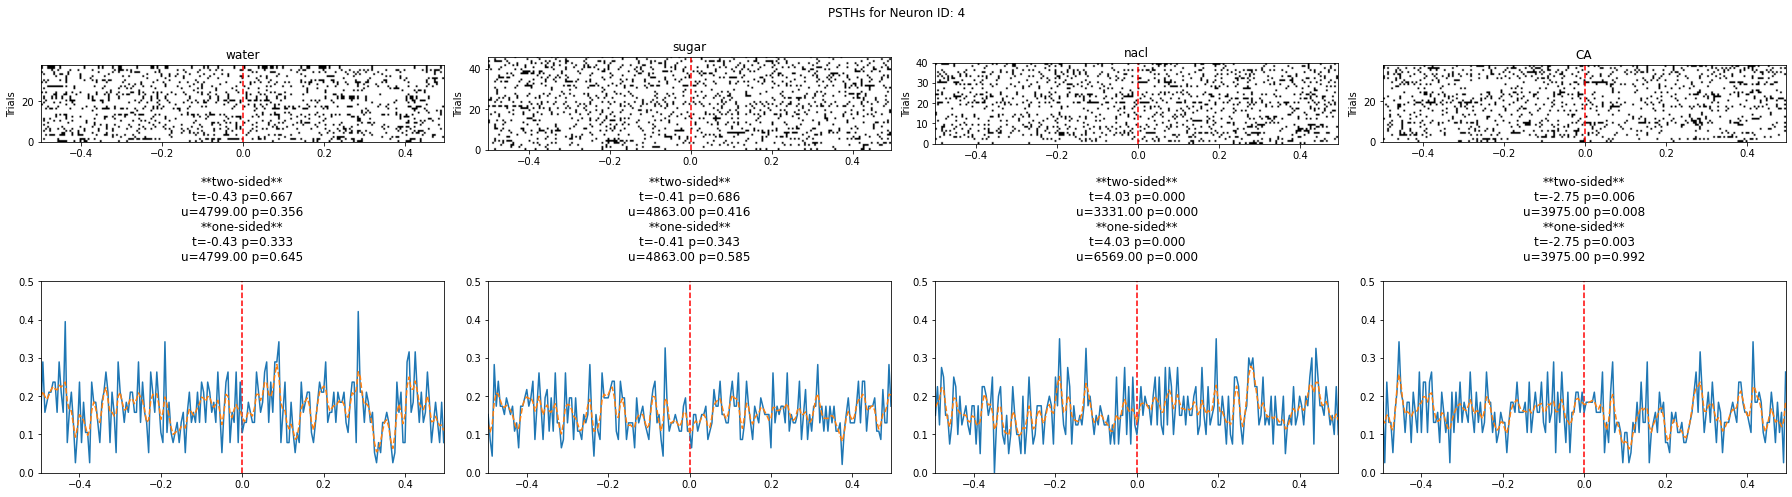

In [14]:
plot_all_tastes_psth(session, 4)

##Selectivity of all Neurons

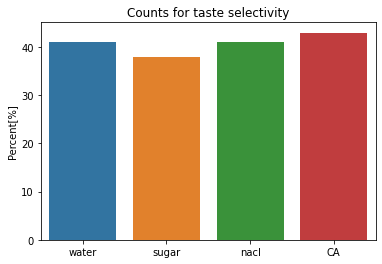

In [15]:
alpha = 0.005
counts = {taste: 0 for taste in tastes}
n_neurons = 0
for session in sd_c.values():
  for neuron_id in range(len(session['neurons'])):
    n_neurons += 1
    for taste in tastes:
      raster, bins = raster_align(session, neuron_id, taste)
      psth = raster.mean(axis=0)
      pre, post = get_pre_post_stim(psth)
      u, p = stats.mannwhitneyu(post, pre, alternative='greater')
      if p <= alpha:
        counts[taste] += 1

sns.barplot(x=list(counts.keys()), y=np.array(list(counts.values()))/n_neurons*100);
plt.ylabel('Percent[%]')
plt.title('Counts for taste selectivity');

##Cross Correlation in the Gustatory Cortex
Katz, D. B., Simon, S. A., L Nicolelis, M. A., Baker, S., Erickson, R., Ghazanfar, A., … Wessberg, J. (2002). Taste-Specific Neuronal Ensembles in the Gustatory Cortex of Awake Rats. In The Journal of Neuroscience (Vol. 22).

In [16]:
def cross_correlation(session, taste, neuron1, neuron2, dt=0.001, time_after_stim=1):
  bins = np.arange(0, time_after_stim, dt)
  r1, _ = raster_align(session, neuron1, taste, bins=bins)
  psth1 = r1.mean(axis=0)
  r2, bins = raster_align(session, neuron2, taste, bins=bins)
  psth2 = r2.mean(axis=0)
  corr = signal.correlate(psth1 - np.mean(psth1), psth2 - np.mean(psth2), 
                          mode='full')
  lags = np.arange(-len(psth2) + 1, len(psth1)) * dt
  return corr, lags


def setup_zscore_plot(ax, maxx, maxy, alpha=0.05):
  z_crit = stats.norm.ppf(1 - alpha)
  ax.set_ylabel('Z-score Values')
  ax.set_xlabel('Lag [sec]');
  ax.hlines(z_crit, -maxx, maxx, linestyles='--')
  ax.hlines(-z_crit, -maxx, maxx, linestyles='--')
  ax.text(-maxx+0.1, z_crit+0.1, f'Alpha={alpha}')
  ax.vlines(0, -maxy, maxy, linestyles='--', colors='k')
  return z_crit

def calc_zscore(corr, smooth_sigma=2):
  z = stats.zscore(corr)
  z = gaussian_filter1d(z, sigma=smooth_sigma)
  return z

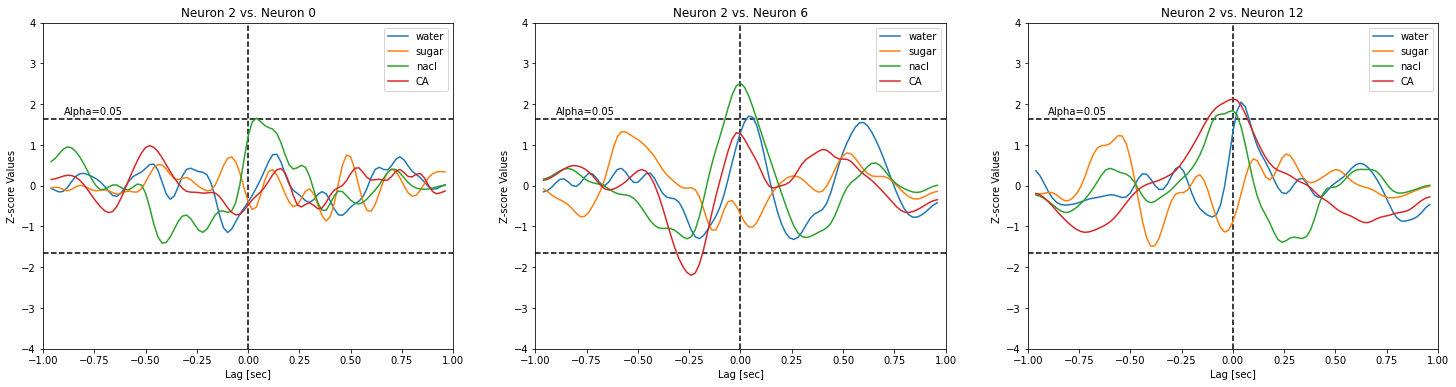

In [17]:
session = sd_c['SDE24']

fig, axes = plt.subplots(1,3,figsize=(25, 6))
maxx, maxy = 1, 4
neuron1 = 2

for i, neuron2 in enumerate([0, 6, 12]):
  z_crit = setup_zscore_plot(axes[i], maxx, maxy)
  for taste in tastes:
    corr, lags = cross_correlation(session, taste, neuron1, neuron2, dt=0.02)  
    z = calc_zscore(corr)
    axes[i].plot(lags, z, label=taste)

  axes[i].set_ylim([-maxy, maxy])
  axes[i].autoscale(enable=True, tight=True)
  axes[i].set_title(f'Neuron {neuron1} vs. Neuron {neuron2}')
  axes[i].legend();

##Palatability
Palatability is the hedonic reward (i.e., pleasure) provided by foods or fluids that are agreeable to the "palate", which often varies relative to the homeostatic satisfaction of nutritional, water, or energy needs. The palatability of a food or fluid, unlike its flavor or taste, varies with the state of an individual: it is lower after consumption and higher when deprived. It has increasingly been appreciated that this can create a hunger that is independent of homeostatic needs. 

https://en.wikipedia.org/wiki/Palatability

In [18]:
bins = np.arange(-0.2, 2, 0.08)

ras = {taste: [] for taste in tastes}
for session in sd_c.values():
  for neuron_id in range(len(session['neurons'])):
    for taste in tastes:
      r, _ = raster_align(session, neuron_id, taste, is_plot=False, bins=bins)
      ras[taste].append(r)

# ras = {k: np.array(v) for k, v in rasters.items()}
ras = np.vstack([np.array(ras[taste]) for taste in tastes]).T

rasm = np.vectorize(lambda x: x.mean(axis=0), otypes='O')(ras)
rasm = np.apply_along_axis(np.mean, 0, rasm)
rasm.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


(27, 4)

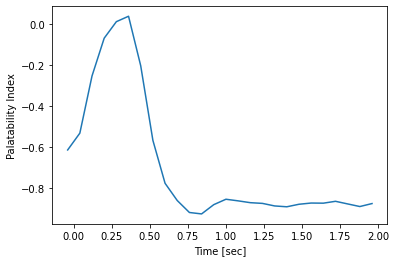

In [19]:
licking_ratios = np.array([4, 5, 3, 0.5])
indices = np.where(bins>-0.1)[0]
pal = np.zeros(indices.shape)
for i, j in enumerate(indices):
  pal[i] = np.corrcoef(rasm[j-1, :], licking_ratios)[0, 1]

plt.plot(bins[indices], gaussian_filter1d(pal, sigma=1))
plt.xlabel('Time [sec]')
plt.ylabel('Palatability Index');